<a href="https://colab.research.google.com/github/NTT123/ai-notebooks/blob/master/Manifold_Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Manifold Mixup: Better Representations by Interpolating Hidden States

https://arxiv.org/abs/1806.05236

Vikas Verma, Alex Lamb, Christopher Beckham, Amir Najafi, Ioannis Mitliagkas, Aaron Courville, David Lopez-Paz, Yoshua Bengio

In [0]:
## I need better style sheet
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('classic')

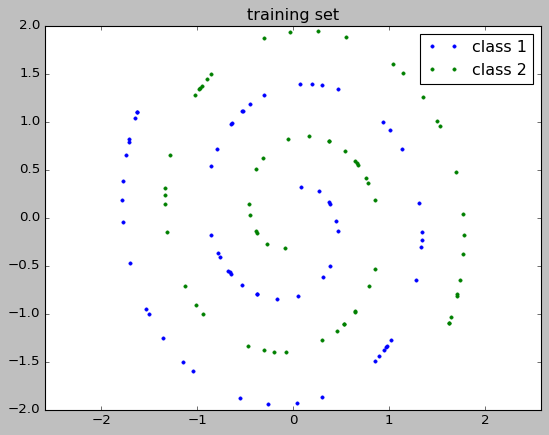

In [2]:
## Two-spirals dataset
## Source: https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html

import numpy as np

np.random.seed(42)

def twospirals(n_points, noise=.1):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 760 * (2*np.pi)/360
    d1x = -np.cos(n)*n + (np.random.rand(n_points,1)-0.5) * noise
    d1y = np.sin(n)*n + (np.random.rand(n_points,1)-0.5) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(64, noise=0.0)
X = X / np.std(X, axis=0, keepdims=True)
plt.axes().set_aspect('equal', 'datalim')

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
_ = plt.legend()


SX = X
Sy = y

In [0]:
from torch.utils.data import DataLoader
dataset = list(zip(X.astype("float32"), y.astype("float32")))
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

In [0]:
import torch
from torch import nn
import numpy as np
from torch.distributions import Beta, Uniform

class MixupLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, lam):
        # x: [batch, dim], lam: [batch]
        x = x * lam + torch.flip(x, [0,]) * (1.0 - lam)
        return x

class MLP(nn.Module):
    def __init__(self, dim=256, bd=2):
        super().__init__()
        self.F = nn.ModuleList([ 
            nn.Linear(2, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, dim), 
            nn.LeakyReLU(0.1),  nn.Linear(dim, bd), MixupLayer(),  nn.Linear(bd, dim), 
            nn.LeakyReLU(0.1), nn.Linear(dim, 1), 
        ])

        self.betaSampler = Beta(torch.tensor([0.1]).float(), torch.tensor([0.1]).float())

    def run_after_mid(self, x):
        t = False
        for f in self.F:
            if t:
                x = f(x)
            if isinstance(f, MixupLayer):
                t = True
                
        return x

    def forward(self, x, no_mixup=False):
        if no_mixup:
            lam = torch.ones( x.size(0), 1)
        else:
            # uniform
            lam = torch.rand(x.size(0), 1) #self.betaSampler.sample( (x.size(0),) ).view(-1, 1)
        lam = lam.to(x.device)
        for f in self.F:
            if isinstance(f, MixupLayer):
                mid = x
                x = f(x, lam) 
            else:
                x = f(x)
        return x, lam, mid

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MLP().to(device)

def init_weights(m):
    g = torch.nn.init.calculate_gain("leaky_relu", 0.1)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=g)
        m.bias.data.fill_(0.01)

net = net.apply(init_weights)
gs = 0
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=0.0)
criterion = torch.nn.BCEWithLogitsLoss()
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("logs/1")

In [6]:
for epoch in range(1000):
    for xx, yy in dataloader:
        xx = xx.to(device)
        yy = yy.to(device).view(-1, 1)

        pred, lam, mid = net(xx, no_mixup=False)

        yyf = torch.flip(yy, dims=[0,])

        y1 = yy * lam + yyf * (1.0 - lam)

        loss = criterion(pred, y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        gs = gs + 1
        writer.add_scalar("loss", loss.item(), gs)
        print("\r epoch: {}, loss: {:0.3f}".format(epoch, loss.item()), end="")

 epoch: 999, loss: 0.214

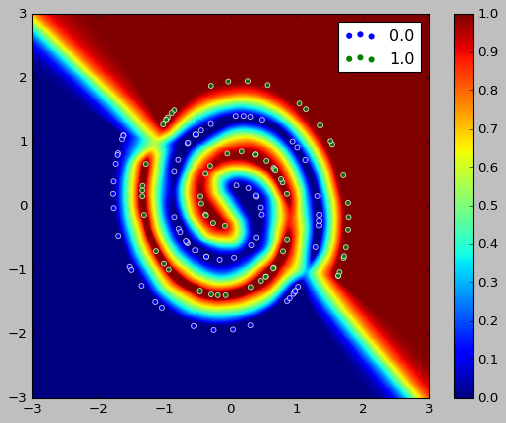

In [7]:
dtt = []
nn=401
vvv = np.linspace(-3,3, nn)
for i in range(nn):
    for j in range(nn):
        xx = vvv[i]
        yy = vvv[j]
        dtt.append([xx,yy])

dtt = np.asarray(dtt).astype("float32")
grd = torch.tensor(dtt).float().to(device)
yg, l, mid = net(grd, no_mixup=True)
yg = torch.sigmoid(yg)
heat = yg.data.cpu().numpy()
heat = heat.reshape((nn,nn))# data.cpu().view(101,101).numpy()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
plt.style.use('classic')

Y, XX = np.meshgrid(vvv, vvv)

plt.pcolormesh(XX, Y, heat )
plt.colorbar()
_ = sns.scatterplot(SX[:, 0], SX[:, 1], hue=Sy, alpha=0.8)


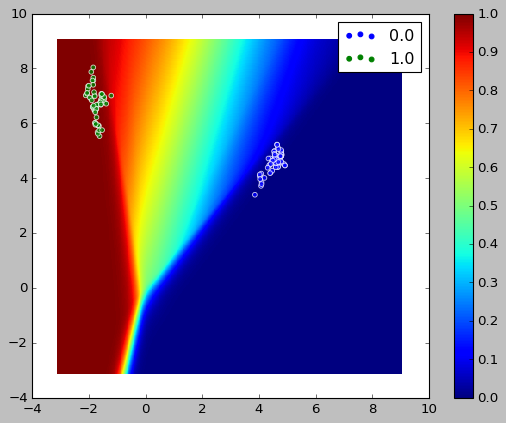

In [8]:
dtt = []


grd= torch.tensor(SX).float().to(device)
yg, l, mid = net(grd, no_mixup=True)
# yg = torch.sigmoid(yg)
# sns.scatterplot( mid[:, 0].data.cpu().numpy(), mid[:, 1].data.cpu().numpy(), hue=Sy, size=1, alpha=0.8 )
mm = torch.min(mid).item() -1 
mmm = torch.max(mid).item() + 1
nn=401
vvv = np.linspace(mm,mmm, nn)
for i in range(nn):
    for j in range(nn):
        xx = vvv[i]
        yy = vvv[j]
        dtt.append([xx,yy])

dtt = np.asarray(dtt).astype("float32")
grd = torch.tensor(dtt).float().to(device)
yg = net.run_after_mid(grd)
yg = torch.sigmoid(yg)
heat = yg.data.cpu().numpy()
heat = heat.reshape((nn,nn))# data.cpu().view(101,101).numpy()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
plt.style.use('classic')

Y, XX = np.meshgrid(vvv, vvv)

plt.pcolormesh(XX, Y, heat )
plt.colorbar()
# _ = sns.scatterplot(SX[:, 0], SX[:, 1], hue=Sy, alpha=0.8)



grd= torch.tensor(SX).float().to(device)
yg, l, mid = net(grd, no_mixup=True)
yg = torch.sigmoid(yg)
sns.scatterplot( mid[:, 0].data.cpu().numpy(), mid[:, 1].data.cpu().numpy(), hue=Sy, size=1, alpha=0.8 )

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 163), started 0:36:24 ago. (Use '!kill 163' to kill it.)